In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [60]:
def read_data():
    with open('names.txt') as f:
        words = f.read().splitlines()
        words_len = len(words)
        words_train_len = int(words_len * 0.8)
        words_dev_len = int(words_len * 0.1)
        words_train = words[:words_train_len]
        words_dev = words[words_train_len:words_train_len+words_dev_len]
        words_test = words[words_train_len+words_dev_len:]
        return words, words_train, words_dev, words_test

In [61]:
words, words_train, words_dev, words_test = read_data()

In [62]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [64]:
chs = sorted(list(set(''.join(words))))
stoi = {v : k+1 for k, v in enumerate(chs)}
stoi['.'] = 0
itos = {v: k for k, v in stoi.items()}
print(itos)
print(len(itos))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [65]:
def prepare_single_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0, 0, 0]
        for ch1 in word + '.':
            X.append(context)
            i = stoi[ch1]
            Y.append(i)
            context = context[1:] + [i]
    return torch.tensor(X), torch.tensor(Y)

In [66]:
def prepare_dataset():
    Xtr, Ytr = prepare_single_dataset(words_train)
    Xdev, Ydev = prepare_single_dataset(words_dev)
    Xtest, Ytest = prepare_single_dataset(words_test)
    return Xtr, Ytr, Xdev, Ydev, Xtest, Ytest

In [68]:
Xtr, Ytr, Xdev, Ydev, Xtest, Ytest = prepare_dataset()
print(Xtr.shape)
print(Ytr.shape)
print(Xdev.shape)
print(Ydev.shape)
print(Xtest.shape)
print(Ytest.shape)

torch.Size([182778, 3])
torch.Size([182778])
torch.Size([22633, 3])
torch.Size([22633])
torch.Size([22735, 3])
torch.Size([22735])


In [138]:
vocab_size = 27
block_size = 3
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

12097


In [139]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if 1 < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad
    
    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break

      0/ 200000: 3.3022
  10000/ 200000: 2.3840
  20000/ 200000: 2.2264
  30000/ 200000: 2.2678
  40000/ 200000: 1.9528
  50000/ 200000: 2.1880
  60000/ 200000: 2.2642
  70000/ 200000: 2.0547
  80000/ 200000: 2.0878
  90000/ 200000: 1.8162
 100000/ 200000: 1.7928
 110000/ 200000: 1.9512
 120000/ 200000: 1.8388
 130000/ 200000: 2.1854
 140000/ 200000: 2.0722
 150000/ 200000: 2.2639
 160000/ 200000: 2.3293
 170000/ 200000: 2.1121
 180000/ 200000: 2.4292
 190000/ 200000: 2.0686


(array([1265.,  239.,  145.,  115.,   95.,   78.,   69.,   73.,   70.,
          56.,   53.,   46.,   52.,   52.,   34.,   39.,   57.,   50.,
          47.,   87.,   85.,   71.,   85.,   99.,   97.,  101.,  108.,
          85.,   88.,   77.,   78.,   62.,   52.,   51.,   44.,   45.,
          52.,   41.,   53.,   51.,   52.,   73.,   67.,   63.,   78.,
         107.,  119.,  184.,  227., 1283.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

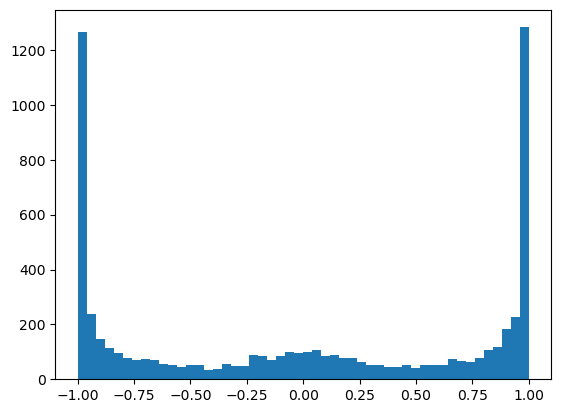

In [114]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   4.,   1.,   2.,   4.,   6.,  12.,  10.,  17.,  13.,  49.,
         58.,  69., 110., 127., 165., 203., 264., 273., 303., 369., 328.,
        419., 380., 439., 389., 358., 330., 283., 309., 279., 192., 148.,
        136., 101.,  89.,  55.,  30.,  22.,  18.,   7.,  10.,   4.,   3.,
          8.,   0.,   0.,   1.,   0.,   2.]),
 array([-3.81970549, -3.65803943, -3.49637337, -3.33470731, -3.17304125,
        -3.01137519, -2.84970913, -2.68804307, -2.52637701, -2.36471095,
        -2.20304489, -2.04137883, -1.87971277, -1.71804671, -1.55638065,
        -1.39471459, -1.23304853, -1.07138247, -0.90971642, -0.74805036,
        -0.5863843 , -0.42471824, -0.26305218, -0.10138612,  0.06027994,
         0.221946  ,  0.38361206,  0.54527812,  0.70694418,  0.86861024,
         1.0302763 ,  1.19194236,  1.35360842,  1.51527448,  1.67694054,
         1.8386066 ,  2.00027266,  2.16193871,  2.32360477,  2.48527083,
         2.64693689,  2.80860295,  2.97026901,  3.13193507,  3.29360113,
 

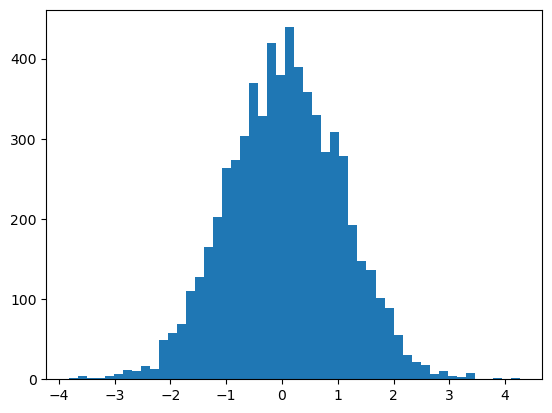

In [106]:
plt.hist(hpreact.view(-1).tolist(), 50)

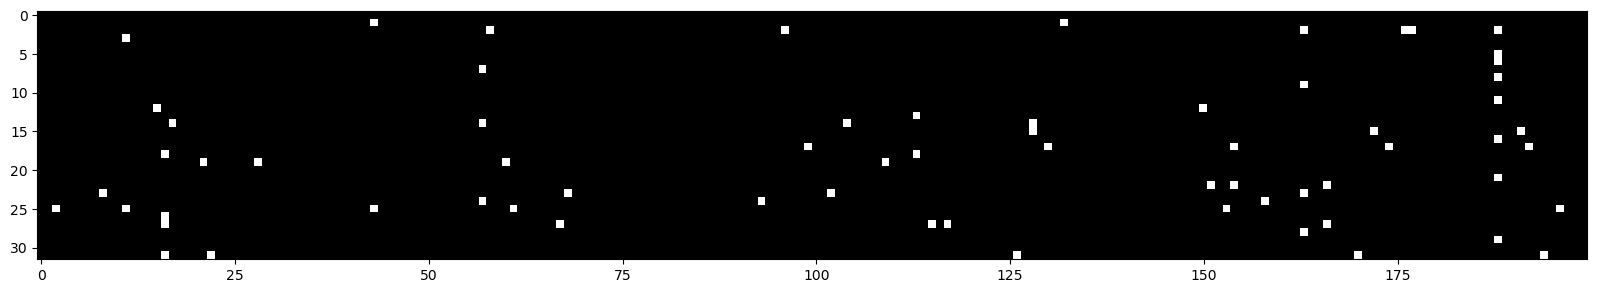

In [107]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

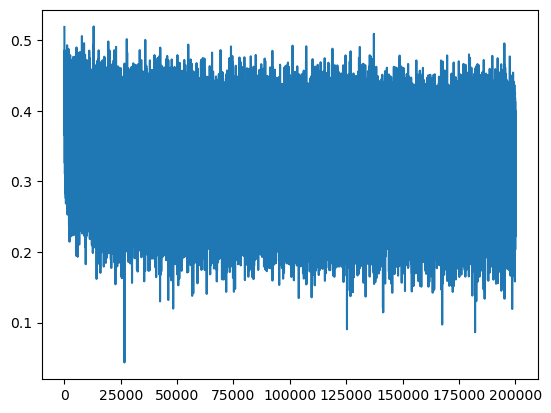

In [142]:
plt.plot(lossi)

In [134]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [143]:
@torch.no_grad
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0837762355804443
val 2.38698148727417


In [141]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1) #+ b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

khal.
ffaturlqeluh.
malghthty.
salfysneffrhnnadaphrrighthn.
xyleannishnmadhvikanaggyah.
maddis.
quintha.
luvaanviubstoruell.
kharissadhxenzirramous.
faviangton.
jasflyshaaghbvathlsyah.
mabostzelluslq.
favashrenlexfatdutum.
zoessa.
bryksrynnlamoklysnraverterryoqselbyx.
daytz.
quunlysbrichrumaygsstyll.
khmirlyannnysantriegs.
sughnnzamayeff.
khaddyah.
